In [1]:
from annotated_datasets import *
import torch.nn as nn
import torch.optim as optim
from models import *
from experiments import *
import pandas as pd
import re
from io_utils import *

In [2]:
'''
from collections import defaultdict
freqs = defaultdict(lambda : 0)
for ant in read_pkl('data/filtered_annotations.pkl'):
    cmt = ant['comments']
    cmt = cmt.lower()
    for word in re.sub('[^A-Za-z0-9 ]+', '', cmt.lower()).split(' '):
        if word in go_dict:
            freqs[word] += 1  
            
go_dict.sort(key=lambda x: -freqs[x])
write_pkl(go_dict, 'data/sorted_go_dict.pkl')
'''

"\nfrom collections import defaultdict\nfreqs = defaultdict(lambda : 0)\nfor ant in read_pkl('data/filtered_annotations.pkl'):\n    cmt = ant['comments']\n    cmt = cmt.lower()\n    for word in re.sub('[^A-Za-z0-9 ]+', '', cmt.lower()).split(' '):\n        if word in go_dict:\n            freqs[word] += 1  \n            \ngo_dict.sort(key=lambda x: -freqs[x])\nwrite_pkl(go_dict, 'data/sorted_go_dict.pkl')\n"

In [3]:
go_dict = read_pkl('data/sorted_go_dict.pkl')
norepeats = []
for w in go_dict:
    if not w in norepeats:
        norepeats.append(w)
key_words = norepeats[:30]

In [4]:
from collections import defaultdict
ants = read_pkl('data/filtered_annotations.pkl')
freqs = defaultdict(lambda : 0)
for ant in ants:
    cmt = ant['comments']
    for word in re.sub('[^A-Za-z0-9 ]+', '', cmt.lower()).split(' '):
        if word.isalpha() and len(word) > 1:
            freqs[word] += 1

words = [(k, freqs[k]) for k in freqs.keys()]
words.sort(key=lambda x: -x[1])
control_words = [w[0] for w in words[:30]]

In [5]:
def better_bag_of_words(words):
    def bow(ant):
        nonlocal words
        cmt = ant['comments']
        cmt = cmt.lower()
        label = np.zeros(len(words))
        for word in re.sub('[^A-Za-z0-9 ]+', '', cmt.lower()).split(' '):
            if word in words:
                label[words.index(word)] = 1
        return label
    return bow  

In [6]:
probe_words = key_words + control_words #fifty each
dataset = get_annotated_dataset('data/filtered_annotations.pkl',
                                seven_planes,
                                better_bag_of_words(probe_words))

In [7]:
import numpy as np
np.sum(np.stack([d[1] for d in dataset]), axis=0)

array([ 15682.,  13413.,  10701.,   9835.,   9416.,   8609.,   6395.,
         6736.,   5727.,   5084.,   5007.,   4692.,   3544.,   3720.,
         3618.,   3363.,   3336.,   2501.,   2705.,   2356.,   2416.,
         2171.,   2163.,   1687.,   1654.,   1481.,   1411.,   1216.,
          968.,    887., 105329.,  91335.,  94699.,  84628.,  67324.,
        47791.,  56742.,  59176.,  48020.,  44574.,  41936.,  40791.,
        44712.,  43446.,  38459.,  36189.,  32694.,  29837.,  32675.,
        31737.,  28743.,  27073.,  26545.,  27934.,  25751.,  27377.,
        23910.,  20690.,  25581.,  25886.])

In [8]:
def cross_validation_run(dataset, get_reprs, init_probes, name, log_dir):
    metric_dfs = []
    for val_idx in range(10):
        chunk_size = len(dataset)//10
        train_dataset = dataset[:val_idx*chunk_size] + dataset[(val_idx+1)*chunk_size:]
        test_dataset = dataset[val_idx*chunk_size:(val_idx+1)*chunk_size]

        probes = init_probes()
        optimizers = [optim.Adam(probes[i].parameters(), lr=0.001) for i in range(len(probes))]

        probe_layers_parallel(train_dataset, test_dataset, get_reprs, probes, optimizers, criterion, num_epochs, log_dir%val_idx)
        
        df = evaluate_auc(test_dataset, get_reprs, probes)
        df['val'] = val_idx
        metric_dfs.append(df)
            
    metric_df = pd.concat(metric_dfs)
    metric_df['name'] = name
    return metric_df

In [9]:
model = load_go_model_from_ckpt('model_ckpt.pth.tar', rm_prefix=True).cuda()
n_channels = [32]
criterion = nn.BCEWithLogitsLoss()
num_epochs = 5
init_probes = lambda : [nn.Sequential(nn.Flatten(), nn.Linear(nc*19*19, len(probe_words))).cuda() for nc in n_channels]

In [10]:
def get_reprs(X):
    X = X.type(torch.FloatTensor).cuda()
    layer_outputs = model.forward_layer_outputs(X)
    return [layer_outputs[-1].detach().cuda()]

aucs = cross_validation_run(dataset, get_reprs, init_probes, 'control', 'control/cv%d')

  0%|                                                                                          | 0/412 [00:00<?, ?it/s]

[0.27189904]


  0%|▍                                                                                 | 2/412 [00:00<00:32, 12.74it/s]

[0.27170646]


  0%|▍                                                                                 | 2/412 [00:00<00:31, 12.98it/s]

[0.27197673]


  0%|▍                                                                                 | 2/412 [00:00<00:31, 12.82it/s]

[0.27236192]


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:04<00:00,  9.23it/s]


[0.27276413]


  0%|                                                                                          | 0/412 [00:00<?, ?it/s]

[0.27231993]


  0%|                                                                                          | 0/412 [00:00<?, ?it/s]

[0.27208504]


  0%|▍                                                                                 | 2/412 [00:00<00:36, 11.36it/s]

[0.27229685]


  0%|▏                                                                                 | 1/412 [00:00<00:41, 10.00it/s]

[0.27263405]


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:04<00:00,  9.48it/s]


[0.27289617]


  0%|                                                                                          | 0/412 [00:00<?, ?it/s]

[0.27831565]


  0%|                                                                                          | 0/412 [00:00<?, ?it/s]

[0.27811647]


  0%|                                                                                          | 0/412 [00:00<?, ?it/s]

[0.27841628]


  0%|▍                                                                                 | 2/412 [00:00<00:32, 12.50it/s]

[0.27874282]


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  8.81it/s]


[0.2792432]


  0%|▏                                                                                 | 1/412 [00:00<00:42,  9.71it/s]

[0.27137872]


  0%|                                                                                          | 0/412 [00:00<?, ?it/s]

[0.27106521]


  0%|▍                                                                                 | 2/412 [00:00<00:34, 11.83it/s]

[0.27121869]


  0%|▍                                                                                 | 2/412 [00:00<00:33, 12.27it/s]

[0.27153766]


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 12.94it/s]


[0.27184629]


  0%|                                                                                          | 0/412 [00:00<?, ?it/s]

[0.27150436]


  0%|▍                                                                                 | 2/412 [00:00<00:35, 11.56it/s]

[0.27120974]


  0%|▍                                                                                 | 2/412 [00:00<00:35, 11.49it/s]

[0.27141927]


  0%|▍                                                                                 | 2/412 [00:00<00:35, 11.56it/s]

[0.27170276]


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 12.68it/s]


[0.27223356]


  0%|                                                                                          | 0/412 [00:00<?, ?it/s]

[0.27693325]


  0%|▍                                                                                 | 2/412 [00:00<00:35, 11.49it/s]

[0.27701078]


  0%|▍                                                                                 | 2/412 [00:00<00:34, 11.83it/s]

[0.27706208]


  0%|▍                                                                                 | 2/412 [00:00<00:30, 13.33it/s]

[0.27746765]


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 13.11it/s]


[0.27792484]


  0%|                                                                                          | 0/412 [00:00<?, ?it/s]

[0.27328278]


  0%|                                                                                          | 0/412 [00:00<?, ?it/s]

[0.27296256]


  0%|▍                                                                                 | 2/412 [00:00<00:31, 13.07it/s]

[0.27297265]


  0%|▍                                                                                 | 2/412 [00:00<00:31, 13.07it/s]

[0.27336069]


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 13.19it/s]


[0.27377542]


  0%|                                                                                          | 0/412 [00:00<?, ?it/s]

[0.26661721]


  0%|▍                                                                                 | 2/412 [00:00<00:34, 11.83it/s]

[0.26644943]


  0%|▍                                                                                 | 2/412 [00:00<00:31, 12.90it/s]

[0.26679346]


  0%|▍                                                                                 | 2/412 [00:00<00:34, 11.90it/s]

[0.26704371]


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 13.19it/s]


[0.26747385]


  0%|                                                                                          | 0/412 [00:00<?, ?it/s]

[0.26538564]


  0%|▍                                                                                 | 2/412 [00:00<00:33, 12.42it/s]

[0.26534334]


  0%|▍                                                                                 | 2/412 [00:00<00:34, 12.05it/s]

[0.26576815]


  0%|                                                                                          | 0/412 [00:00<?, ?it/s]

[0.26591894]


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 12.96it/s]


[0.26645299]


  0%|                                                                                          | 0/412 [00:00<?, ?it/s]

[0.27603797]


  0%|                                                                                          | 0/412 [00:00<?, ?it/s]

[0.27588141]


  0%|▍                                                                                 | 2/412 [00:00<00:31, 12.82it/s]

[0.27621708]


  0%|▍                                                                                 | 2/412 [00:00<00:33, 12.27it/s]

[0.27649808]


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 11.59it/s]


[0.27701393]


In [12]:
write_pkl(aucs, 'controls.pkl')

In [17]:
keyword_aucs = aucs.groupby('kw').mean()['auc'][:30-1].values
control_aucs = aucs.groupby('kw').mean()['auc'][30:].values

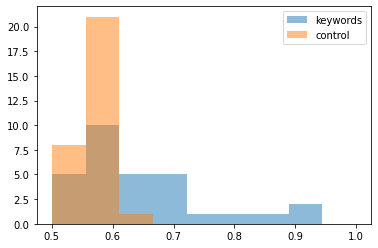

In [18]:
import numpy
import matplotlib.pyplot as plt

x = keyword_aucs
y = control_aucs

bins = numpy.linspace(0.5, 1.0, 10)

plt.hist(x, bins=bins, alpha=0.5, label='keywords')
plt.hist(y, bins=bins, alpha=0.5, label='control')
plt.legend(loc='upper right')
plt.show()